In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from xgcm import Grid
from shapely.ops import cascaded_union
import gsw


In [2]:
# load ROMS avg output
ds = xr.open_dataset("/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0020.nc")
#print(output.variables.keys()) # get all variable names

temp = ds.variables["temp"]
salt = ds.variables["salt"]
ubar = ds.variables["ubar"]
vbar = ds.variables["vbar"]
u = ds.variables["u"]
v = ds.variables["v"]

print(temp.shape)

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    print("Vtransform=1")
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
    print("Vtransform=2")
ds.coords['z_rho'] = z_rho.transpose() # put z_rho into ds dataset

# read grid file for lon/lat coordinates
dg = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
ds.coords['lat_rho']=lat_rho#.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho#.transpose() # put lon_rho into ds dataset

# read waom10_swflx file for (E-P fluxes)
dfw = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_swflux.nc")

dshf = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_shflux_0.25Q.nc")


dfw

(12, 31, 560, 630)
Vtransform=2


<xarray.Dataset>
Dimensions:   (eta_rho: 560, swf_time: 365, xi_rho: 630)
Coordinates:
  * swf_time  (swf_time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    swflux    (swf_time, eta_rho, xi_rho) float64 ...

In [3]:
dens=gsw.rho(salt,temp,0)-1000

In [4]:
print(np.max(np.max(np.max(dens))))
print(np.min(np.min(np.min(dens))))

<xarray.Variable ()>
array(28.07674792)
<xarray.Variable ()>
array(24.00148242)


In [5]:
di = xr.open_dataset("/scratch/project_2000339/boeiradi/NSIDC/seaice_conc_monthly_sh_f13_200701_v03r01.nc")

ice_new = di.variables["seaice_conc_monthly_cdr"]
ice_lon = di.variables["longitude"]
ice_lat = di.variables["latitude"]

#salt = ds.variables["salt"]
print(di)

<xarray.Dataset>
Dimensions:                                 (time: 1, xgrid: 316, ygrid: 332)
Coordinates:
  * time                                    (time) datetime64[ns] 2007-01-01
  * ygrid                                   (ygrid) float32 4337500.0 ... -39...
  * xgrid                                   (xgrid) float32 -3937500.0 ... 39...
    latitude                                (ygrid, xgrid) float64 ...
    longitude                               (ygrid, xgrid) float64 ...
Data variables:
    projection                              |S1 ...
    seaice_conc_monthly_cdr                 (time, ygrid, xgrid) float32 ...
    stdev_of_seaice_conc_monthly_cdr        (time, ygrid, xgrid) float32 ...
    melt_onset_day_seaice_conc_monthly_cdr  (time, ygrid, xgrid) float32 ...
    qa_of_seaice_conc_monthly_cdr           (time, ygrid, xgrid) float32 ...
    goddard_merged_seaice_conc_monthly      (time, ygrid, xgrid) float32 ...
    goddard_nt_seaice_conc_monthly          (time, ygrid, 

/users/boeiradi/.local/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [6]:
projection = di.variables["projection"]

print(projection)

<xarray.Variable ()>
array(b'', dtype='|S1')
Attributes:
    grid_boundary_top_projected_y:          4350000.0
    grid_boundary_bottom_projected_y:       -3950000.0
    grid_boundary_right_projected_x:        3950000.0
    grid_boundary_left_projected_x:         -3950000.0
    parent_grid_cell_row_subset_start:      0.0
    parent_grid_cell_row_subset_end:        332.0
    parent_grid_cell_column_subset_start:   0.0
    parent_grid_cell_column_subset_end:     316.0
    spatial_ref:                            PROJCS["NSIDC Sea Ice Polar Stere...
    proj4text:                              +proj=stere +lat_0=-90 +lat_ts=-7...
    srid:                                   urn:ogc:def:crs:EPSG::3412
    GeoTransform:                           -3950000.0 25000.0 0 4350000.0 0 ...
    grid_mapping_name:                      polar_stereographic
    latitude_of_projection_origin:          -90.0
    standard_parallel:                      -70.0
    straight_vertical_longitude_from_pole:  180.0
 

In [7]:
ice_mm = np.empty((12,332,316))
count=0
for mm in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    di_tmp = xr.open_dataset("/scratch/project_2000339/boeiradi/NSIDC/seaice_conc_monthly_sh_f13_2007" + mm + "_v03r01.nc")

    ice_mm[count,:,:] = di_tmp.variables["seaice_conc_monthly_cdr"]
    if mm == '01':
        ice_lon = di_tmp.variables["longitude"]
        ice_lat = di_tmp.variables["latitude"]
        ice_xgrid = di_tmp.variables["xgrid"]
        ice_ygrid = di_tmp.variables["ygrid"]
    count = count + 1
        

In [8]:
def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    # longitude labels
    ax.text(0,-63.8,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-60,-55,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-120,-54.7,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(180,-62,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    return

proj = ccrs.SouthPolarStereo()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)

bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')

/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


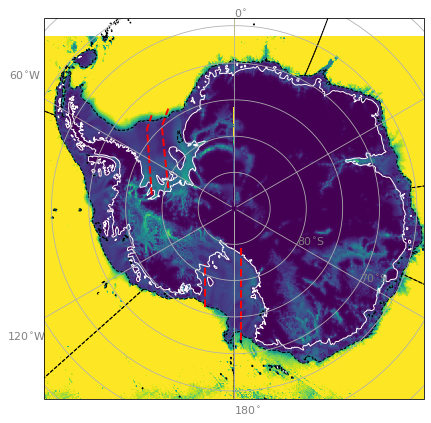

<Figure size 432x288 with 0 Axes>

In [9]:
# sections to investigate Ross-Filchner and Ross IS dynamics:
xi_pt = [175, 200, 255, 310]
eta_sec_ini = [320, 330, 150, 100]
eta_sec_end = [440, 450, 215, 239]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=proj)
cc = plt.pcolormesh(lon_rho.transpose(), lat_rho.transpose(), ds.h, transform=ccrs.PlateCarree(), vmin=0, vmax=3000)
ax.gridlines()
ax.coastlines(resolution='50m',color='white')
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)

# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')

lonlat_labels(ax)
ax.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())

plt.show()

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_Bathym+transects_RF-RIS.png', dpi=300)




<Figure size 640x480 with 0 Axes>

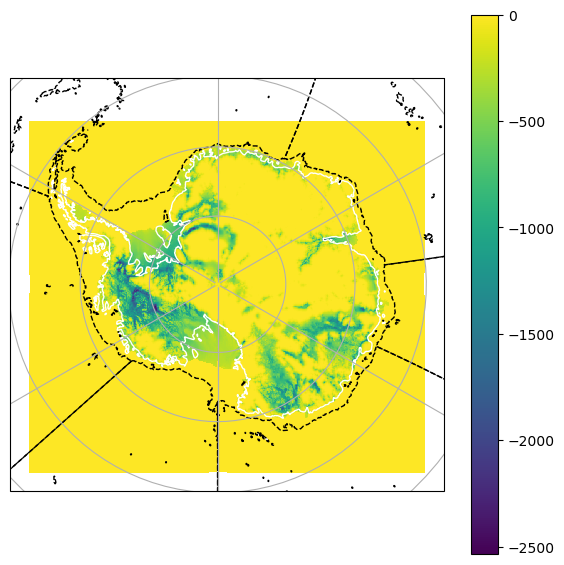

In [10]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=proj)
cc = plt.pcolormesh(lon_rho, lat_rho, ds.zice, transform=ccrs.PlateCarree())#, vmin=0, vmax=3000)
#ci = plt.contour(lon_rho, lat_rho, ds.zice, levels=np.arange(-20,-19,1), color='k', transform=ccrs.PlateCarree())#, vmin=0, vmax=3000)
plt.colorbar(cc)
ax.gridlines()
ax.coastlines(resolution='50m',color='white')
ax.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
plt.show()


/users/boeiradi/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


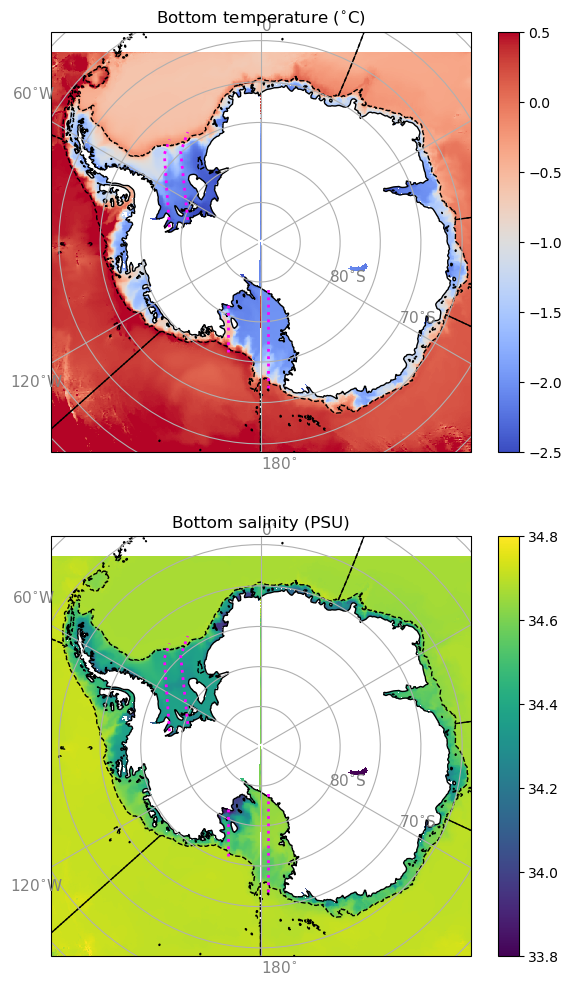

In [11]:
# plots sections with bottom temperature/salinity maps

# Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
fig = plt.figure(figsize=(7,12))
ax1 = fig.add_subplot(211, projection=proj)
ct = plt.pcolormesh(lon_rho, lat_rho, temp.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=-2.5, vmax=.5, cmap=plt.cm.coolwarm)
plt.colorbar(ct)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
lonlat_labels(ax1)
#ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())
plt.title('Bottom temperature ($^{\circ}$C)')

ax2 = fig.add_subplot(212, projection=proj)
cs = plt.pcolormesh(lon_rho, lat_rho, salt.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=33.8, vmax=34.8, cmap=plt.cm.viridis)
plt.colorbar(cs)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
lonlat_labels(ax2)
#ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())
plt.title('Bottom salinity (PSU)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_temp-salt+transects_RF-RIS.png', dpi=300)

plt.show()

In [10]:
# Handle interpolation from u and v grid to rho points:

ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta + ds.zice
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta + ds.zice

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=False)

u_rho_bot = np.zeros((12,560,630))
v_rho_bot = np.zeros((12,560,630))
ubar_rho = np.zeros((12,560,630))
vbar_rho = np.zeros((12,560,630))

for mm in np.arange(0,12):
    #interpoate u, v to rho grid:
    u_interp = grid.interp(ds.u.isel(s_rho=0,ocean_time=mm), 'X',boundary='fill')
    v_interp = grid.interp(ds.v.isel(s_rho=0,ocean_time=mm), 'Y',boundary='fill')
    u_rho_bot[mm,:,:]=u_interp
    v_rho_bot[mm,:,:]=v_interp
    del u_interp,v_interp

    u_interp = grid.interp(ds.ubar.isel(ocean_time=mm), 'X',boundary='fill')
    v_interp = grid.interp(ds.vbar.isel(ocean_time=mm), 'Y',boundary='fill')
    ubar_rho[mm,:,:]=u_interp
    vbar_rho[mm,:,:]=v_interp
    del u_interp,v_interp
    

In [11]:
# time average 
u_bot = np.squeeze(np.nanmean(u_rho_bot,axis=0))
v_bot = np.squeeze(np.nanmean(v_rho_bot,axis=0))
print('u_bot, v_bot, lat, lon sizes=', u_bot.shape, v_bot.shape, lon_rho.shape, lat_rho.shape)
vel_bot = np.sqrt(np.square(u_bot) + np.square(v_bot))

ubar = np.squeeze(np.nanmean(ubar_rho,axis=0))
vbar = np.squeeze(np.nanmean(vbar_rho,axis=0))
vel_bar = np.sqrt(np.square(ubar) + np.square(vbar))

# call cartopy projectione
proj = ccrs.SouthPolarStereo()

# re-gridding
src = ccrs.SouthPolarStereo()
nx, ny = 630, 560
xscale= [-.308e7, .345e7]
yscale= [-.308e7, .267e7]
xs = np.linspace(xscale[0], xscale[1], nx)
ys = np.linspace(yscale[0], yscale[1], ny)

xs, ys = np.meshgrid(xs, ys)

u_bot, v_bot, lat, lon sizes= (560, 630) (560, 630) (560, 630) (560, 630)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


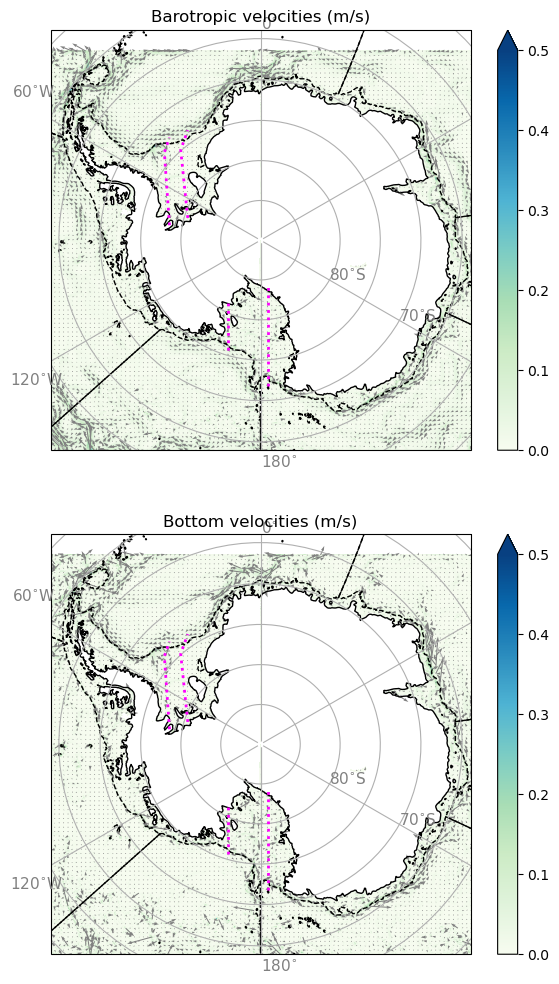

In [14]:
# plots sections with bottom X barotropic velocities

fig = plt.figure(figsize=(7,12))
ax1 = fig.add_subplot(211, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bar, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],ubar[::6,::6],vbar[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
lonlat_labels(ax1)
ax1.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())
plt.title('Barotropic velocities (m/s)')

ax2 = fig.add_subplot(212, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bot, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax2.quiver(xs[::6,::6],ys[::6,::6],u_bot[::6,::6],v_bot[::6,::6], color='gray', transform=src)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
lonlat_labels(ax2)
ax2.set_extent([-180, 180, -90, -64], ccrs.PlateCarree())
plt.title('Bottom velocities (m/s)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_currents+transects_RF-RIS.png', dpi=300)

plt.show()

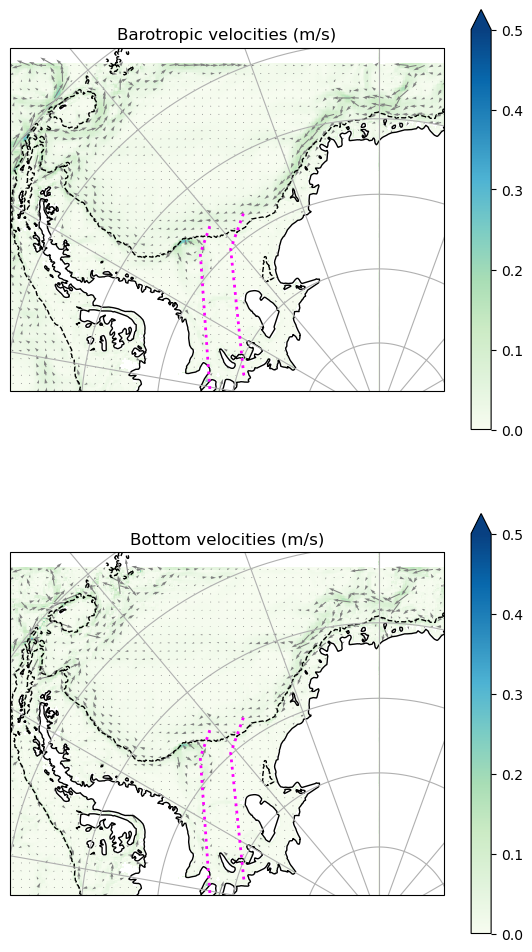

In [15]:
# plots sections with bottom X barotropic velocities: Weddell Sea region

fig = plt.figure(figsize=(7,12))
ax1 = fig.add_subplot(211, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bar, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],ubar[::6,::6],vbar[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax1)
ax1.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Barotropic velocities (m/s)')

ax2 = fig.add_subplot(212, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bot, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax2.quiver(xs[::6,::6],ys[::6,::6],u_bot[::6,::6],v_bot[::6,::6], color='gray', transform=src)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax2)
ax2.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Bottom velocities (m/s)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_currents+transects_RFIS.png', dpi=300)

plt.show()

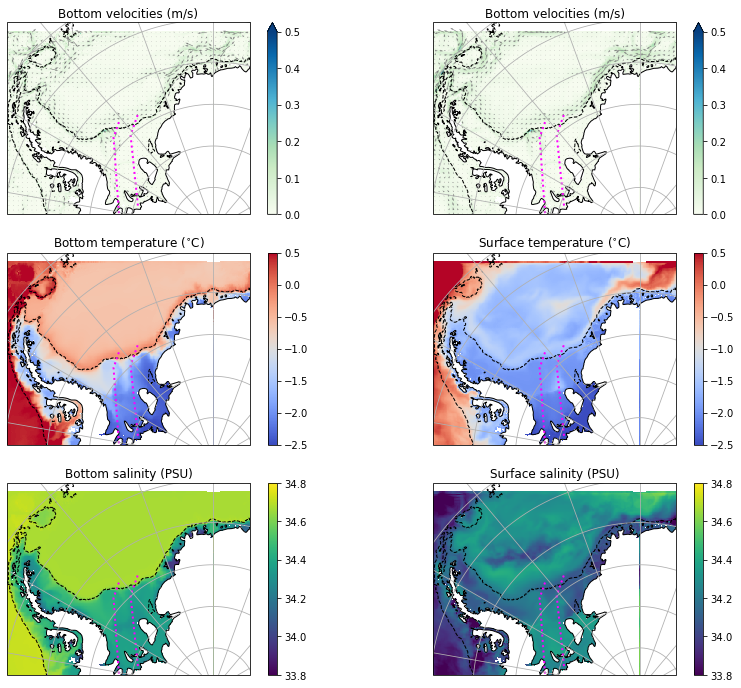

In [15]:
# plots bottom velocity, temperature, salinity: Weddell Sea region

fig = plt.figure(figsize=(14,12))

ax1 = fig.add_subplot(321, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bot, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],u_bot[::6,::6],v_bot[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax1)
ax1.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Bottom velocities (m/s)')

ax2 = fig.add_subplot(323, projection=proj)
ct = plt.pcolormesh(lon_rho, lat_rho, temp.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=-2.5, vmax=.5, cmap=plt.cm.coolwarm)
plt.colorbar(ct)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax2.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Bottom temperature ($^{\circ}$C)')

ax3 = fig.add_subplot(325, projection=proj)
cs = plt.pcolormesh(lon_rho, lat_rho, salt.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=33.8, vmax=34.8, cmap=plt.cm.viridis)
plt.colorbar(cs)
ax3.gridlines()
ax3.coastlines(resolution='50m',color='black')
ax3.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax3.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Bottom salinity (PSU)')

ax1 = fig.add_subplot(322, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bar, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],ubar[::6,::6],vbar[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax1)
ax1.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Barotropic velocities (m/s)')

ax2 = fig.add_subplot(324, projection=proj)
ct = plt.pcolormesh(lon_rho, lat_rho, temp.isel(s_rho=-1).mean(axis=0), transform=ccrs.PlateCarree(), vmin=-2.5, vmax=.5, cmap=plt.cm.coolwarm)
plt.colorbar(ct)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax2.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Surface temperature ($^{\circ}$C)')

ax3 = fig.add_subplot(326, projection=proj)
cs = plt.pcolormesh(lon_rho, lat_rho, salt.isel(s_rho=-1).mean(axis=0), transform=ccrs.PlateCarree(), vmin=33.8, vmax=34.8, cmap=plt.cm.viridis)
plt.colorbar(cs)
ax3.gridlines()
ax3.coastlines(resolution='50m',color='black')
ax3.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax3.set_extent([-80, 10, -80, -65], ccrs.PlateCarree())
plt.title('Surface salinity (PSU)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_bottom_sfc_velTS+transects_RFIS.png', dpi=300)

plt.show()

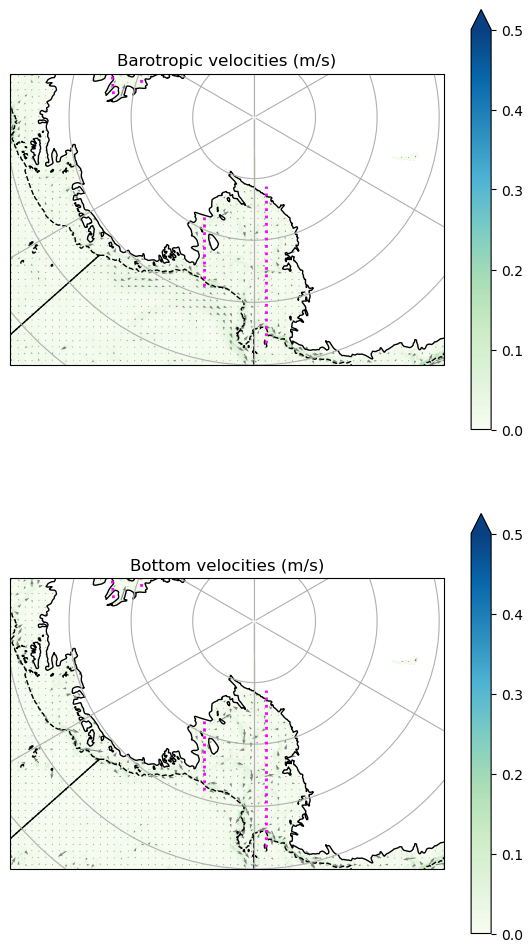

In [17]:
# plots sections with bottom X barotropic velocities: Ross Sea region

fig = plt.figure(figsize=(7,12))
ax1 = fig.add_subplot(211, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bar, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],ubar[::6,::6],vbar[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax1)
ax1.set_extent([130, 280, -85, -70], ccrs.PlateCarree())
plt.title('Barotropic velocities (m/s)')

ax2 = fig.add_subplot(212, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bot, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax2.quiver(xs[::6,::6],ys[::6,::6],u_bot[::6,::6],v_bot[::6,::6], color='gray', transform=src)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax2)
ax2.set_extent([130, 280, -85, -70], ccrs.PlateCarree())
plt.title('Bottom velocities (m/s)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_currents+transects_RIS.png', dpi=300)

plt.show()

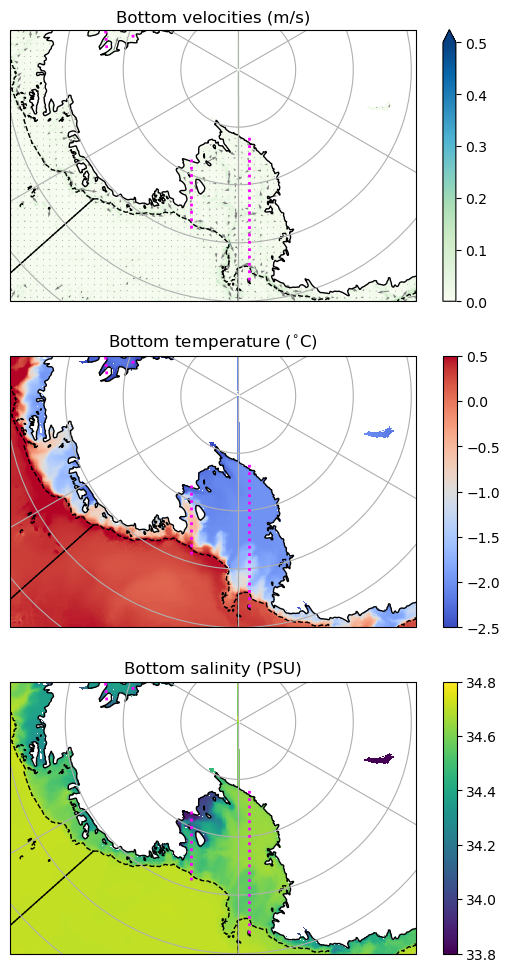

In [18]:
# plots bottom velocity, temperature, salinity: Weddell Sea region

fig = plt.figure(figsize=(7,12))

ax1 = fig.add_subplot(311, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bot, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],u_bot[::6,::6],v_bot[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax1)
ax1.set_extent([130, 280, -85, -70], ccrs.PlateCarree())
plt.title('Bottom velocities (m/s)')

ax2 = fig.add_subplot(312, projection=proj)
ct = plt.pcolormesh(lon_rho, lat_rho, temp.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=-2.5, vmax=.5, cmap=plt.cm.coolwarm)
plt.colorbar(ct)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax2.set_extent([130, 280, -85, -70], ccrs.PlateCarree())
plt.title('Bottom temperature ($^{\circ}$C)')

ax3 = fig.add_subplot(313, projection=proj)
cs = plt.pcolormesh(lon_rho, lat_rho, salt.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=33.8, vmax=34.8, cmap=plt.cm.viridis)
plt.colorbar(cs)
ax3.gridlines()
ax3.coastlines(resolution='50m',color='black')
ax3.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax3.set_extent([130, 280, -85, -70], ccrs.PlateCarree())
plt.title('Bottom salinity (PSU)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_bottom_velTS+transects_RIS.png', dpi=300)

plt.show()

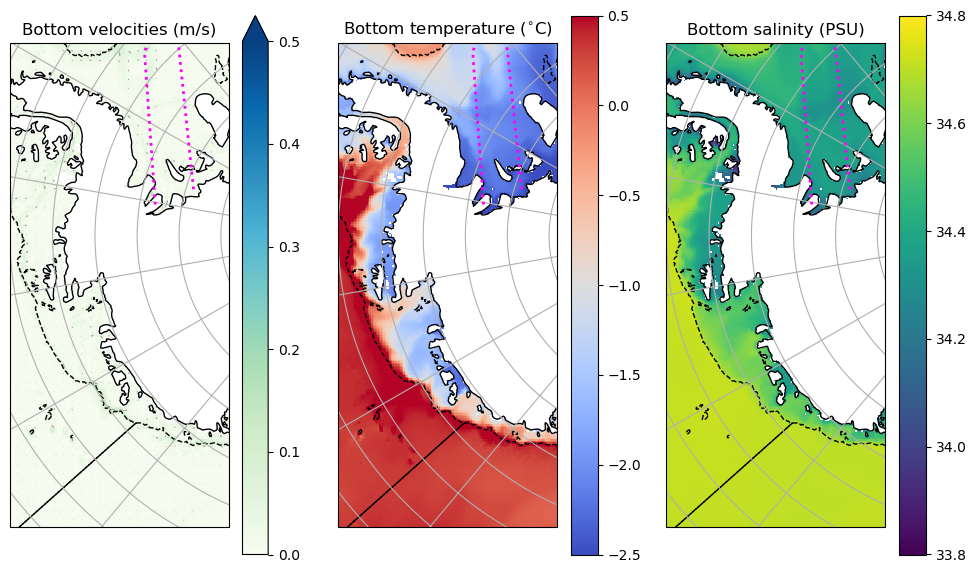

In [17]:
# plots bottom velocity, temperature, salinity: West Antarctica

fig = plt.figure(figsize=(12,7))

ax1 = fig.add_subplot(131, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bot, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],u_bot[::6,::6],v_bot[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax1)
ax1.set_extent([-150, -55, -76, -70], ccrs.PlateCarree())
plt.title('Bottom velocities (m/s)')

ax2 = fig.add_subplot(132, projection=proj)
ct = plt.pcolormesh(lon_rho, lat_rho, temp.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=-2.5, vmax=.5, cmap=plt.cm.coolwarm)
plt.colorbar(ct)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax2.set_extent([-150, -55, -76, -70], ccrs.PlateCarree())
plt.title('Bottom temperature ($^{\circ}$C)')

ax3 = fig.add_subplot(133, projection=proj)
cs = plt.pcolormesh(lon_rho, lat_rho, salt.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=33.8, vmax=34.8, cmap=plt.cm.viridis)
plt.colorbar(cs)
ax3.gridlines()
ax3.coastlines(resolution='50m',color='black')
ax3.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax3.set_extent([-150, -55, -76, -70], ccrs.PlateCarree())
plt.title('Bottom salinity (PSU)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_bottom_velTS+transects_WAnt.png', dpi=300)

plt.show()

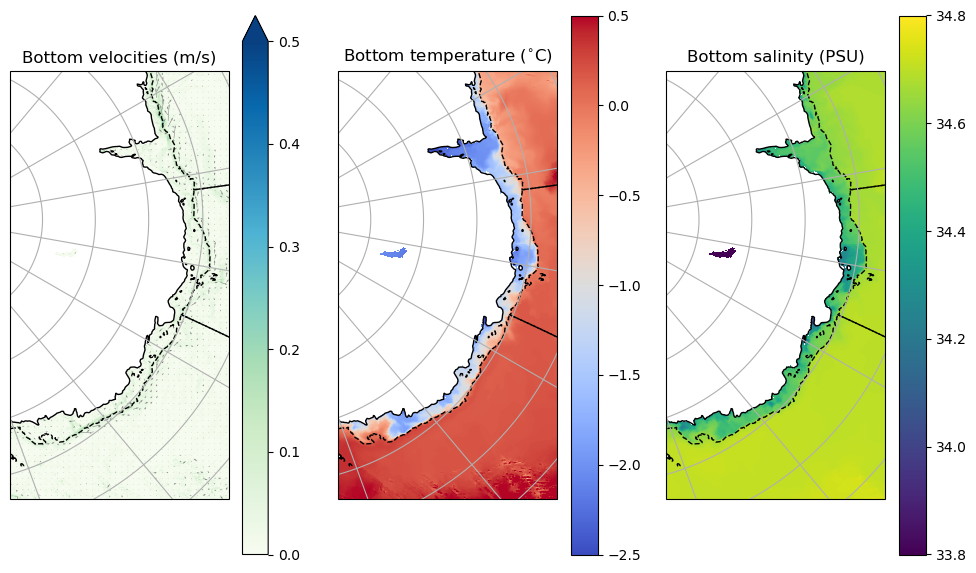

In [18]:
# plots bottom velocity, temperature, salinity: East Antarctica

fig = plt.figure(figsize=(12,7))

ax1 = fig.add_subplot(131, projection=proj)
cs=plt.pcolormesh(lon_rho,lat_rho,vel_bot, transform=ccrs.PlateCarree(), cmap=plt.cm.GnBu, vmin=0, vmax=.5)
cbars =fig.colorbar(cs, extend='max')
cv=ax1.quiver(xs[::6,::6],ys[::6,::6],u_bot[::6,::6],v_bot[::6,::6], color='gray', transform=src)
ax1.gridlines()
ax1.coastlines(resolution='50m',color='black')
ax1.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
#lonlat_labels(ax1)
ax1.set_extent([60, 160, -70, -62], ccrs.PlateCarree())
plt.title('Bottom velocities (m/s)')

ax2 = fig.add_subplot(132, projection=proj)
ct = plt.pcolormesh(lon_rho, lat_rho, temp.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=-2.5, vmax=.5, cmap=plt.cm.coolwarm)
plt.colorbar(ct)
ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax2.set_extent([60, 160, -70, -62], ccrs.PlateCarree())
plt.title('Bottom temperature ($^{\circ}$C)')

ax3 = fig.add_subplot(133, projection=proj)
cs = plt.pcolormesh(lon_rho, lat_rho, salt.isel(s_rho=0).mean(axis=0), transform=ccrs.PlateCarree(), vmin=33.8, vmax=34.8, cmap=plt.cm.viridis)
plt.colorbar(cs)
ax3.gridlines()
ax3.coastlines(resolution='50m',color='black')
ax3.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='magenta',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dotted')
ax3.set_extent([60, 160, -70, -62], ccrs.PlateCarree())
plt.title('Bottom salinity (PSU)')

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_bottom_velTS+transects_EAnt.png', dpi=300)

plt.show()

/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


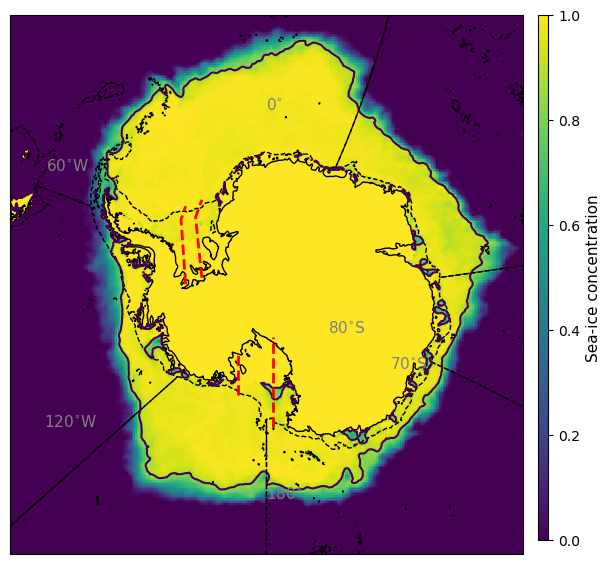

In [19]:

fig = plt.figure(figsize=(7,7))

ax2 = fig.add_subplot(111, projection=proj)
ci = plt.pcolor(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[8,:,:]), transform=ccrs.Stereographic(**kw), vmin=0, vmax=1)
cc = plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[8,:,:]),color='white', levels=[.85], transform=ccrs.Stereographic(**kw))
# Weddell
ii=0
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')
ii=1
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')
# Ross Sea
ii=2
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')
ii=3
plt.plot([lon_rho[eta_sec_ini[ii],xi_pt[ii]], lon_rho[eta_sec_end[ii],xi_pt[ii]]],[lat_rho[eta_sec_ini[ii],xi_pt[ii]], lat_rho[eta_sec_end[ii],xi_pt[ii]]],color='red',transform=ccrs.PlateCarree(),linewidth=2, linestyle='dashed')

#ax2.gridlines()
ax2.coastlines(resolution='50m',color='black')
ax2.add_feature(bathym, facecolor='none', edgecolor='black', linestyle='dashed', linewidth=1)
lonlat_labels(ax2)
# colorbar
cbar_axim = fig.add_axes([0.9, 0.13, 0.015, 0.75])
cbar =fig.colorbar(ci, cax=cbar_axim)
plt.ylabel('Sea-ice concentration',fontsize=11)

plt.savefig('/users/boeiradi/COLD_project/postprocessing/figs/WAOM10extend_NSIDC_September_sea-ice+transects_RF-RIS.png', dpi=300)

plt.show()

In [20]:
print(ds.h.transpose().shape, lon_rho.shape, lat_rho.shape)


(630, 560) (560, 630) (560, 630)


In [21]:
# Weddell Sea
# 1 - slice section for salt/temp/z_rho
section_salt_wedW = np.empty((12,31,120)) # allocating
section_temp_wedW = np.empty((12,31,120))
section_rho_wedW = np.empty((12,31,120))
section_z_wedW = np.empty((12,31,120))
section_z_wedW_mask = np.empty((12,31,120))

section_zice_wedW = ds.zice.isel(xi_rho=xi_pt[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]))
for mm in np.arange(0,12):
    section_salt_wedW[mm,:,:] = ds.salt.isel(xi_rho=xi_pt[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm)
    section_temp_wedW[mm,:,:] = ds.temp.isel(xi_rho=xi_pt[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm)
    section_z_wedW[mm,:,:] = ds.z_rho.isel(xi_rho=xi_pt[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]), ocean_time=mm)
    section_rho_wedW[mm,:,:] = np.squeeze(dens[mm,:,eta_sec_ini[0]:eta_sec_end[0],xi_pt[0]])
    # 1.1 - add ice draft to z_rho depths:
    #section_z_wedW[mm,-1,:] = section_z_wedW[mm,-1:]+section_zice_wedW
    # 1.2 - mask land values in z_rho slice                                           
    section_z_wedW_mask[mm,:,:] = ma.array(section_z_wedW[mm,:,:],mask=np.isnan(section_z_wedW[mm,:,:]))
    
# 2 - slide section for lon or lat
section_lat_wedW_tmp = ds.lat_rho.isel(xi_rho=xi_pt[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_wedW = np.ones((31,120))                                                
for ii in np.arange(0,31):
    section_lat_wedW[ii,:] = section_lat_wedW_tmp
section_lat_wedW_mask = ma.array(section_lat_wedW,mask=np.isnan(section_z_wedW[0,:,:]))

print(section_lat_wedW.shape, section_z_wedW.shape, section_salt_wedW.shape)

## season averages:
section_z_wedW_mask_JFM = np.squeeze(np.nanmean(section_z_wedW_mask[0:2,:,:], axis=0))
section_z_wedW_mask_AMJ = np.squeeze(np.nanmean(section_z_wedW_mask[3:5,:,:], axis=0))
section_z_wedW_mask_JAS = np.squeeze(np.nanmean(section_z_wedW_mask[6:8,:,:], axis=0))
section_z_wedW_mask_OND = np.squeeze(np.nanmean(section_z_wedW_mask[9:11,:,:], axis=0))

section_temp_wedW_JFM = np.squeeze(np.nanmean(section_temp_wedW[0:2,:,:], axis=0))
section_temp_wedW_AMJ = np.squeeze(np.nanmean(section_temp_wedW[3:5,:,:], axis=0))
section_temp_wedW_JAS = np.squeeze(np.nanmean(section_temp_wedW[6:8,:,:], axis=0))
section_temp_wedW_OND = np.squeeze(np.nanmean(section_temp_wedW[9:11,:,:], axis=0))

section_salt_wedW_JFM = np.squeeze(np.nanmean(section_salt_wedW[0:2,:,:], axis=0))
section_salt_wedW_AMJ = np.squeeze(np.nanmean(section_salt_wedW[3:5,:,:], axis=0))
section_salt_wedW_JAS = np.squeeze(np.nanmean(section_salt_wedW[6:8,:,:], axis=0))
section_salt_wedW_OND = np.squeeze(np.nanmean(section_salt_wedW[9:11,:,:], axis=0))

section_rho_wedW_JFM = np.squeeze(np.nanmean(section_rho_wedW[0:2,:,:], axis=0))
section_rho_wedW_AMJ = np.squeeze(np.nanmean(section_rho_wedW[3:5,:,:], axis=0))
section_rho_wedW_JAS = np.squeeze(np.nanmean(section_rho_wedW[6:8,:,:], axis=0))
section_rho_wedW_OND = np.squeeze(np.nanmean(section_rho_wedW[9:11,:,:], axis=0))

section_z_wedW_mask_ann = np.squeeze(np.nanmean(section_z_wedW_mask[:,:,:], axis=0))
section_temp_wedW_ann = np.squeeze(np.nanmean(section_temp_wedW[:,:,:], axis=0))
section_salt_wedW_ann = np.squeeze(np.nanmean(section_salt_wedW[:,:,:], axis=0))
section_rho_wedW_ann = np.squeeze(np.nanmean(section_rho_wedW[:,:,:], axis=0))

print(section_lat_wedW.shape, section_z_wedW_mask_JFM.shape, section_salt_wedW_JFM.shape)

(31, 120) (12, 31, 120) (12, 31, 120)
(31, 120) (31, 120) (31, 120)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site

In [22]:
# Weddell Sea
# 1 - slice section for salt/temp/z_rho
section_salt_wedE = np.empty((12,31,120)) # allocating
section_temp_wedE = np.empty((12,31,120))
section_rho_wedE = np.empty((12,31,120))
section_z_wedE = np.empty((12,31,120))
section_z_wedE_mask = np.empty((12,31,120))

section_zice_wedE = ds.zice.isel(xi_rho=xi_pt[1], eta_rho=slice(eta_sec_ini[1],eta_sec_end[1]))
for mm in np.arange(0,12):
    section_salt_wedE[mm,:,:] = ds.salt.isel(xi_rho=xi_pt[1], eta_rho=slice(eta_sec_ini[1],eta_sec_end[1]), ocean_time=mm)
    section_temp_wedE[mm,:,:] = ds.temp.isel(xi_rho=xi_pt[1], eta_rho=slice(eta_sec_ini[1],eta_sec_end[1]), ocean_time=mm)
    section_z_wedE[mm,:,:] = ds.z_rho.isel(xi_rho=xi_pt[1], eta_rho=slice(eta_sec_ini[1],eta_sec_end[1]), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_wedE_mask[mm,:,:] = ma.array(section_z_wedE[mm,:,:],mask=np.isnan(section_z_wedE[mm,:,:]))
    section_rho_wedE[mm,:,:] = np.squeeze(dens[mm,:,eta_sec_ini[1]:eta_sec_end[1],xi_pt[1]])
        
# 2 - slide section for lon or lat
section_lat_wedE_tmp = ds.lat_rho.isel(xi_rho=xi_pt[1], eta_rho=slice(eta_sec_ini[1],eta_sec_end[1]))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_wedE = np.ones((31,120))                                                
for ii in np.arange(0,31):
    section_lat_wedE[ii,:] = section_lat_wedE_tmp
section_lat_wedE_mask = ma.array(section_lat_wedE,mask=np.isnan(section_z_wedE[0,:,:]))

print(section_lat_wedE.shape, section_z_wedE.shape, section_salt_wedE.shape)

## season averages:
section_z_wedE_mask_JFM = np.squeeze(np.nanmean(section_z_wedE_mask[0:2,:,:], axis=0))
section_z_wedE_mask_AMJ = np.squeeze(np.nanmean(section_z_wedE_mask[3:5,:,:], axis=0))
section_z_wedE_mask_JAS = np.squeeze(np.nanmean(section_z_wedE_mask[6:8,:,:], axis=0))
section_z_wedE_mask_OND = np.squeeze(np.nanmean(section_z_wedE_mask[9:11,:,:], axis=0))

section_temp_wedE_JFM = np.squeeze(np.nanmean(section_temp_wedE[0:2,:,:], axis=0))
section_temp_wedE_AMJ = np.squeeze(np.nanmean(section_temp_wedE[3:5,:,:], axis=0))
section_temp_wedE_JAS = np.squeeze(np.nanmean(section_temp_wedE[6:8,:,:], axis=0))
section_temp_wedE_OND = np.squeeze(np.nanmean(section_temp_wedE[9:11,:,:], axis=0))

section_salt_wedE_JFM = np.squeeze(np.nanmean(section_salt_wedE[0:2,:,:], axis=0))
section_salt_wedE_AMJ = np.squeeze(np.nanmean(section_salt_wedE[3:5,:,:], axis=0))
section_salt_wedE_JAS = np.squeeze(np.nanmean(section_salt_wedE[6:8,:,:], axis=0))
section_salt_wedE_OND = np.squeeze(np.nanmean(section_salt_wedE[9:11,:,:], axis=0))

section_rho_wedE_JFM = np.squeeze(np.nanmean(section_rho_wedE[0:2,:,:], axis=0))
section_rho_wedE_AMJ = np.squeeze(np.nanmean(section_rho_wedE[3:5,:,:], axis=0))
section_rho_wedE_JAS = np.squeeze(np.nanmean(section_rho_wedE[6:8,:,:], axis=0))
section_rho_wedE_OND = np.squeeze(np.nanmean(section_rho_wedE[9:11,:,:], axis=0))

section_z_wedE_mask_ann = np.squeeze(np.nanmean(section_z_wedE_mask[:,:,:], axis=0))
section_temp_wedE_ann = np.squeeze(np.nanmean(section_temp_wedE[:,:,:], axis=0))
section_salt_wedE_ann = np.squeeze(np.nanmean(section_salt_wedE[:,:,:], axis=0))
section_rho_wedE_ann = np.squeeze(np.nanmean(section_rho_wedE[:,:,:], axis=0))

print(section_lat_wedE.shape, section_z_wedE_mask_JFM.shape, section_salt_wedE_JFM.shape)

(31, 120) (12, 31, 120) (12, 31, 120)
(31, 120) (31, 120) (31, 120)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site

(31, 120) (31, 120) (120,)


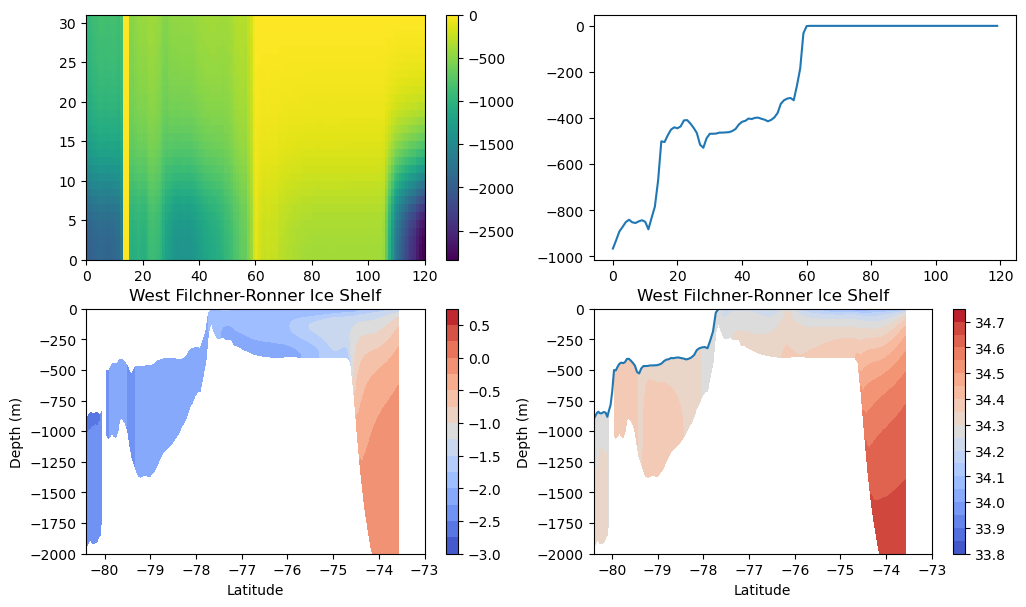

In [36]:
#section_zice_wedE = ds.zice.isel(xi_rho=xi_pt[0], eta_rho=slice(eta_sec_ini[0],eta_sec_end[0]))

print(section_z_wedE_mask_ann.shape, section_lat_wedE_mask.shape, section_zice_wedE.shape)

#section_z_wedE_mask_ann_zice = section_z_wedE_mask_ann
#section_z_wedE_mask_ann_zice[-1,:] = section_z_wedE_mask_ann_zice[-1,:]+section_zice_wedE

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,2,1)
ct = plt.pcolormesh(section_z_wedE_mask_ann)
plt.colorbar(ct)

ax2 = fig.add_subplot(2,2,2)
ct = plt.plot(section_zice_wedE)

ax3 = fig.add_subplot(2,2,3)
#ct = plt.pcolormesh(section_lat_wedE_mask, section_z_wedE_mask_ann, section_temp_wedE_ann, vmin=-3, vmax=1)#, levels=np.arange(-3.,1.,.25), cmap=plt.cm.coolwarm)
ct = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_ann, section_temp_wedE_ann, levels=np.arange(-3.,1.,.25), cmap=plt.cm.coolwarm)
#ct = plt.contour(section_lat_wedE_mask, section_z_wedE_mask_ann, section_temp_wedE_ann, colors='k', levels=np.arange(-3.,1,.25))
plt.colorbar(ct)
plt.xlim([-80.4,-73.])
plt.ylim([-2000,0])
plt.title('West Filchner-Ronner Ice Shelf')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax4 = fig.add_subplot(2,2,4)
#ct = plt.pcolormesh(section_lat_wedE_mask, section_z_wedE_mask_ann, section_salt_wedE_ann, vmin=33, vmax=35)#, levels=np.arange(33.8,34.8,.05), cmap=plt.cm.coolwarm)
ct = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_ann, section_salt_wedE_ann, levels=np.arange(33.8,34.8,.05), cmap=plt.cm.coolwarm)
#ct = plt.contour(section_lat_wedE_mask, section_z_wedE_mask_ann, section_salt_wedE_ann, colors='k', levels=np.arange(33.8,34.8,.05))
plt.plot(section_lat_wedE_mask[0,:],section_zice_wedE)
plt.colorbar(ct)
plt.xlim([-80.4,-73.])
plt.ylim([-2000,0])
plt.title('West Filchner-Ronner Ice Shelf')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

plt.show()

In [24]:
# Ross Sea
# 1 - slice section for salt/temp/z_rho
section_salt_rosE = np.empty((12,31,65)) # allocating
section_temp_rosE = np.empty((12,31,65))
section_rho_rosE = np.empty((12,31,65))
section_z_rosE = np.empty((12,31,65))
section_z_rosE_mask = np.empty((12,31,65))

for mm in np.arange(0,12):
    section_salt_rosE[mm,:,:] = ds.salt.isel(xi_rho=xi_pt[2], eta_rho=slice(eta_sec_ini[2],eta_sec_end[2]), ocean_time=mm)
    section_temp_rosE[mm,:,:] = ds.temp.isel(xi_rho=xi_pt[2], eta_rho=slice(eta_sec_ini[2],eta_sec_end[2]), ocean_time=mm)
    section_z_rosE[mm,:,:] = ds.z_rho.isel(xi_rho=xi_pt[2], eta_rho=slice(eta_sec_ini[2],eta_sec_end[2]), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_rosE_mask[mm,:,:] = ma.array(section_z_rosE[mm,:,:],mask=np.isnan(section_z_rosE[mm,:,:]))
    section_rho_rosE[mm,:,:] = np.squeeze(dens[mm,:,eta_sec_ini[2]:eta_sec_end[2],xi_pt[2]])
       
# 2 - slide section for lon or lat
section_lat_rosE_tmp = ds.lat_rho.isel(xi_rho=xi_pt[2], eta_rho=slice(eta_sec_ini[2],eta_sec_end[2]))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_rosE = np.ones((31,65))                                                
for ii in np.arange(0,31):
    section_lat_rosE[ii,:] = section_lat_rosE_tmp
section_lat_rosE_mask = ma.array(section_lat_rosE,mask=np.isnan(section_z_rosE[0,:,:]))

print(section_lat_rosE.shape, section_z_rosE.shape, section_salt_rosE.shape)

## season averages:
section_z_rosE_mask_JFM = np.squeeze(np.nanmean(section_z_rosE_mask[0:2,:,:], axis=0))
section_z_rosE_mask_AMJ = np.squeeze(np.nanmean(section_z_rosE_mask[3:5,:,:], axis=0))
section_z_rosE_mask_JAS = np.squeeze(np.nanmean(section_z_rosE_mask[6:8,:,:], axis=0))
section_z_rosE_mask_OND = np.squeeze(np.nanmean(section_z_rosE_mask[9:11,:,:], axis=0))

section_temp_rosE_JFM = np.squeeze(np.nanmean(section_temp_rosE[0:2,:,:], axis=0))
section_temp_rosE_AMJ = np.squeeze(np.nanmean(section_temp_rosE[3:5,:,:], axis=0))
section_temp_rosE_JAS = np.squeeze(np.nanmean(section_temp_rosE[6:8,:,:], axis=0))
section_temp_rosE_OND = np.squeeze(np.nanmean(section_temp_rosE[9:11,:,:], axis=0))

section_salt_rosE_JFM = np.squeeze(np.nanmean(section_salt_rosE[0:2,:,:], axis=0))
section_salt_rosE_AMJ = np.squeeze(np.nanmean(section_salt_rosE[3:5,:,:], axis=0))
section_salt_rosE_JAS = np.squeeze(np.nanmean(section_salt_rosE[6:8,:,:], axis=0))
section_salt_rosE_OND = np.squeeze(np.nanmean(section_salt_rosE[9:11,:,:], axis=0))

section_rho_rosE_JFM = np.squeeze(np.nanmean(section_rho_rosE[0:2,:,:], axis=0))
section_rho_rosE_AMJ = np.squeeze(np.nanmean(section_rho_rosE[3:5,:,:], axis=0))
section_rho_rosE_JAS = np.squeeze(np.nanmean(section_rho_rosE[6:8,:,:], axis=0))
section_rho_rosE_OND = np.squeeze(np.nanmean(section_rho_rosE[9:11,:,:], axis=0))

section_z_rosE_mask_ann = np.squeeze(np.nanmean(section_z_rosE_mask[:,:,:], axis=0))
section_temp_rosE_ann = np.squeeze(np.nanmean(section_temp_rosE[:,:,:], axis=0))
section_salt_rosE_ann = np.squeeze(np.nanmean(section_salt_rosE[:,:,:], axis=0))
section_rho_rosE_ann = np.squeeze(np.nanmean(section_rho_rosE[:,:,:], axis=0))

print(section_lat_rosE.shape, section_z_rosE_mask_JFM.shape, section_salt_rosE_JFM.shape)

(31, 65) (12, 31, 65) (12, 31, 65)
(31, 65) (31, 65) (31, 65)


In [25]:
# Ross Sea
# 1 - slice section for salt/temp/z_rho
section_salt_rosW = np.empty((12,31,139)) # allocating
section_temp_rosW = np.empty((12,31,139))
section_rho_rosW = np.empty((12,31,139))
section_z_rosW = np.empty((12,31,139))
section_z_rosW_mask = np.empty((12,31,139))

for mm in np.arange(0,12):
    section_salt_rosW[mm,:,:] = ds.salt.isel(xi_rho=xi_pt[3], eta_rho=slice(eta_sec_ini[3],eta_sec_end[3]), ocean_time=mm)
    section_temp_rosW[mm,:,:] = ds.temp.isel(xi_rho=xi_pt[3], eta_rho=slice(eta_sec_ini[3],eta_sec_end[3]), ocean_time=mm)
    section_z_rosW[mm,:,:] = ds.z_rho.isel(xi_rho=xi_pt[3], eta_rho=slice(eta_sec_ini[3],eta_sec_end[3]), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_rosW_mask[mm,:,:] = ma.array(section_z_rosW[mm,:,:],mask=np.isnan(section_z_rosW[mm,:,:]))
    section_rho_rosW[mm,:,:] = np.squeeze(dens[mm,:,eta_sec_ini[3]:eta_sec_end[3],xi_pt[3]])
        
# 2 - slide section for lon or lat
section_lat_rosW_tmp = ds.lat_rho.isel(xi_rho=xi_pt[3], eta_rho=slice(eta_sec_ini[3],eta_sec_end[3]))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_rosW = np.ones((31,139))                                                
for ii in np.arange(0,31):
    section_lat_rosW[ii,:] = section_lat_rosW_tmp
section_lat_rosW_mask = ma.array(section_lat_rosW,mask=np.isnan(section_z_rosW[0,:,:]))

print(section_lat_rosW.shape, section_z_rosW.shape, section_salt_rosW.shape)

## season averages:
section_z_rosW_mask_JFM = np.squeeze(np.nanmean(section_z_rosW_mask[0:2,:,:], axis=0))
section_z_rosW_mask_AMJ = np.squeeze(np.nanmean(section_z_rosW_mask[3:5,:,:], axis=0))
section_z_rosW_mask_JAS = np.squeeze(np.nanmean(section_z_rosW_mask[6:8,:,:], axis=0))
section_z_rosW_mask_OND = np.squeeze(np.nanmean(section_z_rosW_mask[9:11,:,:], axis=0))

section_temp_rosW_JFM = np.squeeze(np.nanmean(section_temp_rosW[0:2,:,:], axis=0))
section_temp_rosW_AMJ = np.squeeze(np.nanmean(section_temp_rosW[3:5,:,:], axis=0))
section_temp_rosW_JAS = np.squeeze(np.nanmean(section_temp_rosW[6:8,:,:], axis=0))
section_temp_rosW_OND = np.squeeze(np.nanmean(section_temp_rosW[9:11,:,:], axis=0))

section_salt_rosW_JFM = np.squeeze(np.nanmean(section_salt_rosW[0:2,:,:], axis=0))
section_salt_rosW_AMJ = np.squeeze(np.nanmean(section_salt_rosW[3:5,:,:], axis=0))
section_salt_rosW_JAS = np.squeeze(np.nanmean(section_salt_rosW[6:8,:,:], axis=0))
section_salt_rosW_OND = np.squeeze(np.nanmean(section_salt_rosW[9:11,:,:], axis=0))

section_rho_rosW_JFM = np.squeeze(np.nanmean(section_rho_rosW[0:2,:,:], axis=0))
section_rho_rosW_AMJ = np.squeeze(np.nanmean(section_rho_rosW[3:5,:,:], axis=0))
section_rho_rosW_JAS = np.squeeze(np.nanmean(section_rho_rosW[6:8,:,:], axis=0))
section_rho_rosW_OND = np.squeeze(np.nanmean(section_rho_rosW[9:11,:,:], axis=0))

section_z_rosW_mask_ann = np.squeeze(np.nanmean(section_z_rosW_mask[:,:,:], axis=0))
section_temp_rosW_ann = np.squeeze(np.nanmean(section_temp_rosW[:,:,:], axis=0))
section_salt_rosW_ann = np.squeeze(np.nanmean(section_salt_rosW[:,:,:], axis=0))
section_rho_rosW_ann = np.squeeze(np.nanmean(section_rho_rosW[:,:,:], axis=0))

print(section_lat_rosW.shape, section_z_rosW_mask_JFM.shape, section_salt_rosW_JFM.shape)

(31, 139) (12, 31, 139) (12, 31, 139)
(31, 139) (31, 139) (31, 139)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site

In [26]:
fig_path='/users/boeiradi/COLD_project/postprocessing/figs/Cross_sections/'


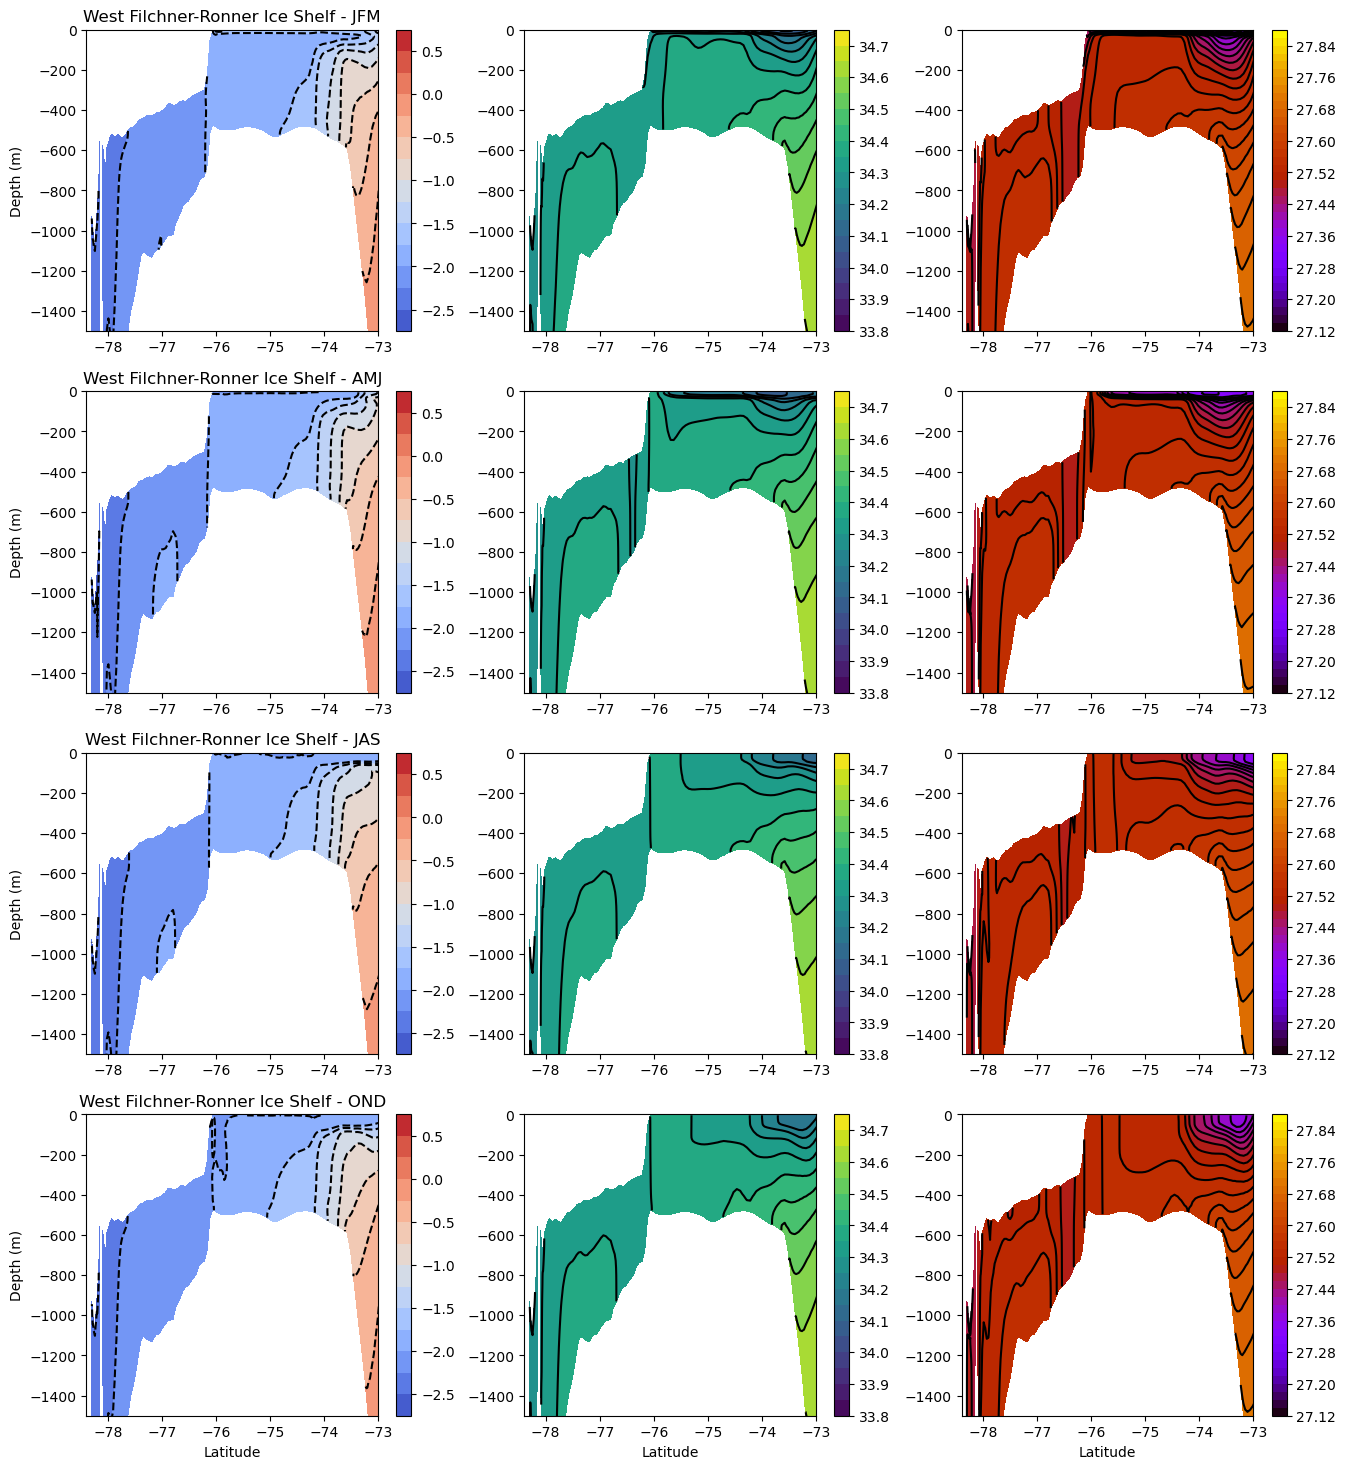

In [27]:
# Plot transects: Seasonal

levelsT = np.arange(-2.75,0.76,.25)
levelsS = np.arange(33.8,34.8,.05)
levelsR = np.arange(27.12,27.9,.02)

# Weddell West
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_temp_wedW_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_temp_wedW_JFM, colors='k', levels=levelsT)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_rho_wedW_JFM, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
plt.title('West Filchner-Ronner Ice Shelf - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_salt_wedW_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_salt_wedW_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_rho_wedW_JFM, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_rho_wedW_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JFM, section_rho_wedW_JFM, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_temp_wedW_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_temp_wedW_AMJ, colors='k', levels=levelsT)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_rho_wedW_AMJ, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
plt.title('West Filchner-Ronner Ice Shelf - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_salt_wedW_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_salt_wedW_AMJ, colors='k', levels=levelsS)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_rho_wedW_AMJ, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_rho_wedW_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_AMJ, section_rho_wedW_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_temp_wedW_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_temp_wedW_JAS, colors='k', levels=levelsT)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_rho_wedW_JAS, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
plt.title('West Filchner-Ronner Ice Shelf - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_salt_wedW_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_salt_wedW_JAS, colors='k', levels=levelsS)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_rho_wedW_JAS, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_rho_wedW_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_JAS, section_rho_wedW_JAS, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_OND, section_temp_wedW_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_OND, section_temp_wedW_OND, colors='k', levels=levelsT)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_OND, section_rho_wedW_OND, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
plt.title('West Filchner-Ronner Ice Shelf - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_OND, section_salt_wedW_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_OND, section_salt_wedW_OND, colors='k', levels=levelsS)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_OND, section_rho_wedW_OND, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_OND, section_rho_wedW_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_OND, section_rho_wedW_OND, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

name_fig="waom10extend_wedW_section_seas_yr20.png"
plt.savefig(fig_path + name_fig)

plt.show()

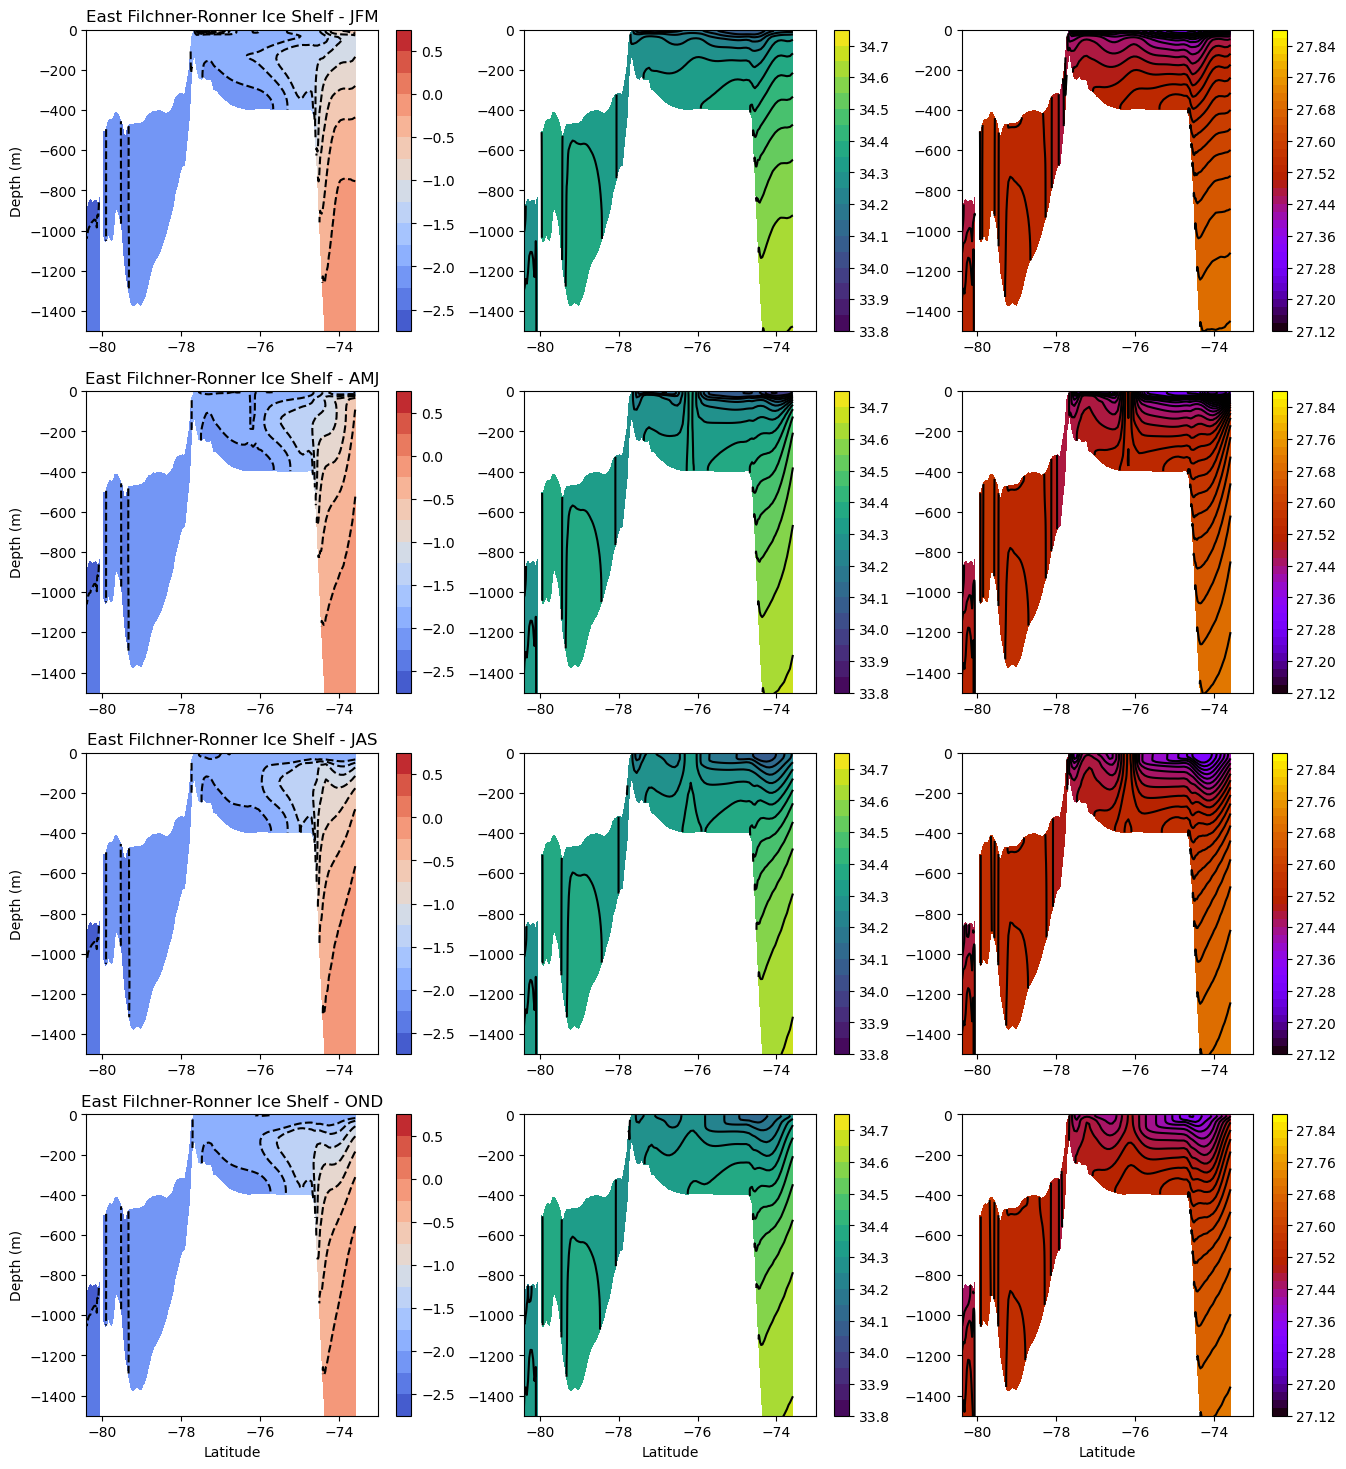

In [37]:
# Plot transects: Seasonal

# Weddell East
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_temp_wedE_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_temp_wedE_JFM, colors='k', levels=levelsT)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_rho_wedE_JFM, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
plt.title('East Filchner-Ronner Ice Shelf - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_salt_wedE_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_salt_wedE_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_rho_wedE_JFM, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_rho_wedE_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JFM, section_rho_wedE_JFM, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_temp_wedE_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_temp_wedE_AMJ, colors='k', levels=levelsT)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_rho_wedE_AMJ, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
plt.title('East Filchner-Ronner Ice Shelf - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_salt_wedE_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_salt_wedE_AMJ, colors='k', levels=levelsS)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_rho_wedE_AMJ, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_rho_wedE_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_AMJ, section_rho_wedE_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_temp_wedE_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_temp_wedE_JAS, colors='k', levels=levelsT)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_rho_wedE_JAS, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
plt.title('East Filchner-Ronner Ice Shelf - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_salt_wedE_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_salt_wedE_JAS, colors='k', levels=levelsS)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_rho_wedE_JAS, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_rho_wedE_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_JAS, section_rho_wedE_JAS, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_OND, section_temp_wedE_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_OND, section_temp_wedE_OND, colors='k', levels=levelsT)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_OND, section_rho_wedE_OND, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
plt.title('East Filchner-Ronner Ice Shelf - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_OND, section_salt_wedE_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_OND, section_salt_wedE_OND, colors='k', levels=levelsS)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_OND, section_rho_wedE_OND, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_OND, section_rho_wedE_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_OND, section_rho_wedE_OND, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

name_fig="waom10extend_wedE_section_seas_yr20.png"
plt.savefig(fig_path + name_fig)

plt.show()

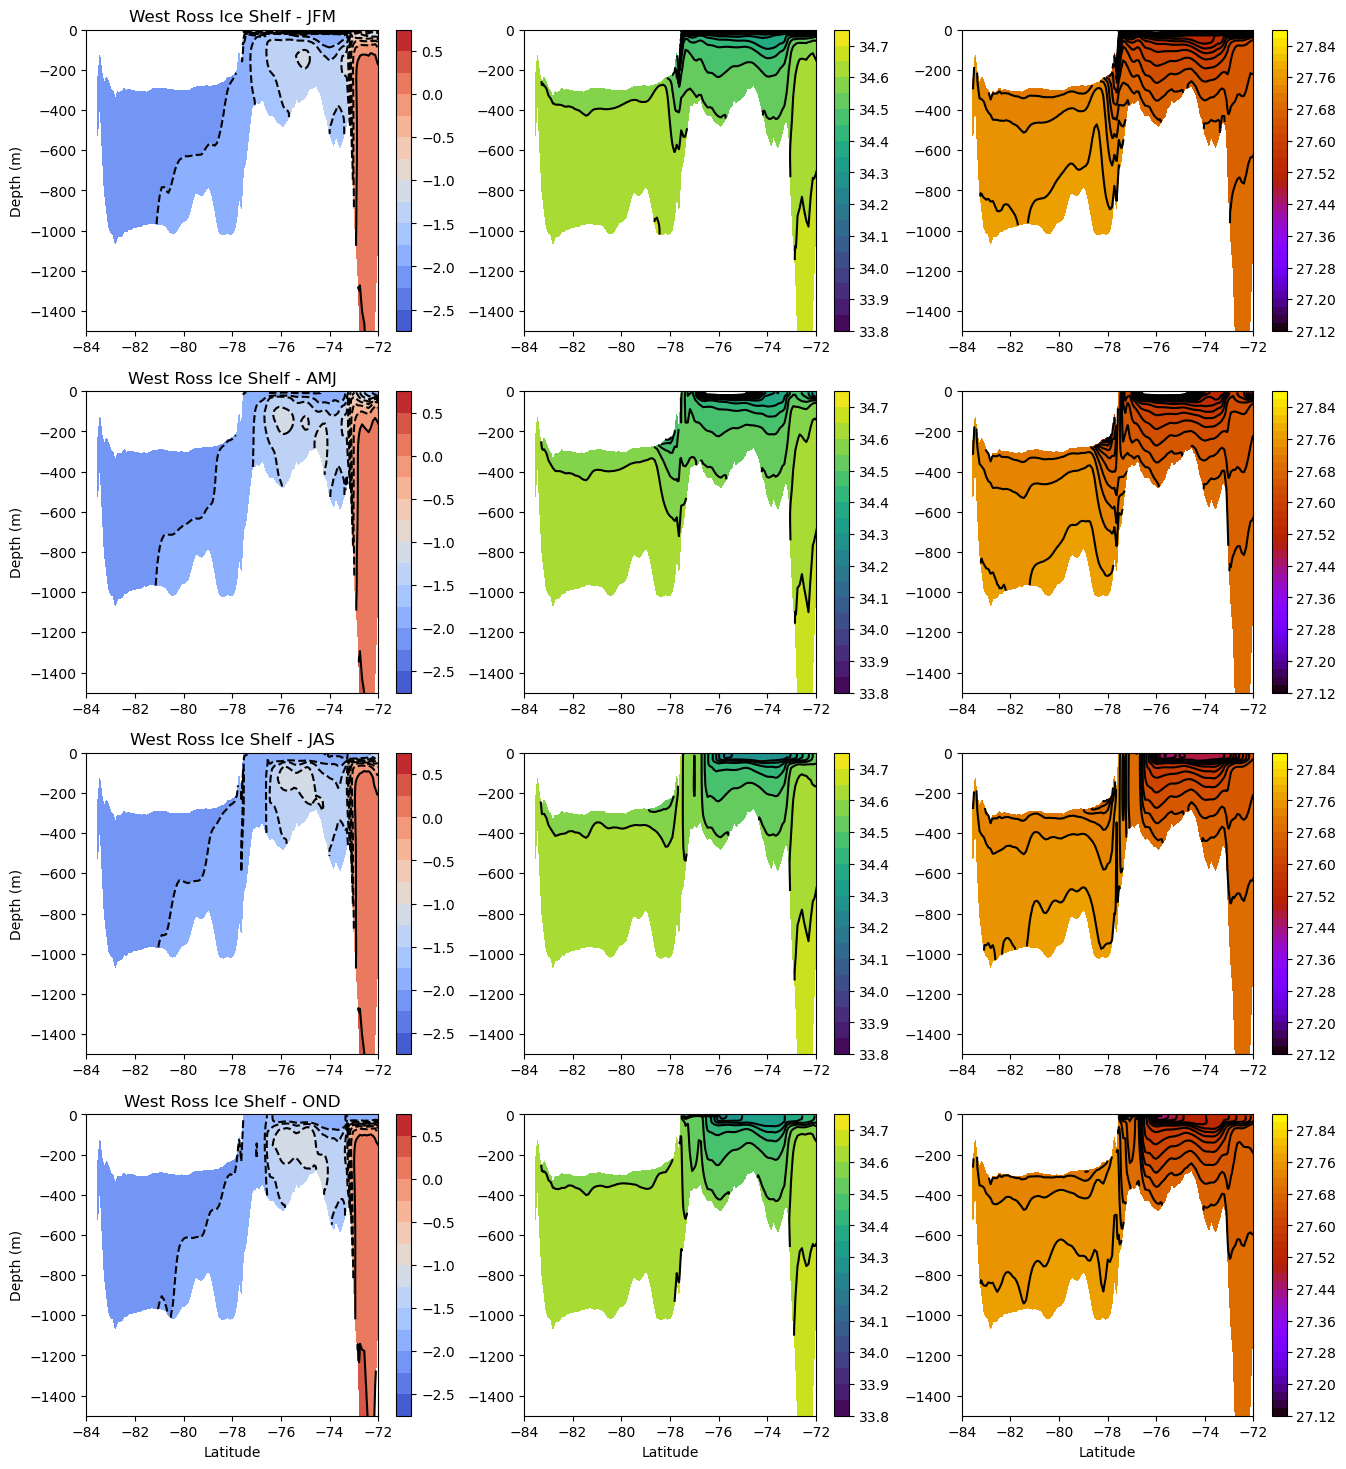

In [29]:
# Plot transects: Seasonal

# Ross West
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_temp_rosW_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_temp_rosW_JFM, colors='k', levels=levelsT)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_rho_rosW_JFM, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
plt.title('West Ross Ice Shelf - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_salt_rosW_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_salt_rosW_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_rho_rosW_JFM, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_rho_rosW_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JFM, section_rho_rosW_JFM, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_temp_rosW_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_temp_rosW_AMJ, colors='k', levels=levelsT)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_rho_rosW_AMJ, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
plt.title('West Ross Ice Shelf - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_salt_rosW_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_salt_rosW_AMJ, colors='k', levels=levelsS)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_rho_rosW_AMJ, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_rho_rosW_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_AMJ, section_rho_rosW_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_temp_rosW_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_temp_rosW_JAS, colors='k', levels=levelsT)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_rho_rosW_JAS, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
plt.title('West Ross Ice Shelf - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_salt_rosW_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_salt_rosW_JAS, colors='k', levels=levelsS)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_rho_rosW_JAS, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_rho_rosW_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_JAS, section_rho_rosW_JAS, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_OND, section_temp_rosW_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_OND, section_temp_rosW_OND, colors='k', levels=levelsT)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_OND, section_rho_rosW_OND, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
plt.title('West Ross Ice Shelf - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_OND, section_salt_rosW_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_OND, section_salt_rosW_OND, colors='k', levels=levelsS)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_OND, section_rho_rosW_OND, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_OND, section_rho_rosW_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_OND, section_rho_rosW_OND, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

name_fig="waom10extend_rosW_section_seas_yr20.png"
plt.savefig(fig_path + name_fig)

plt.show()

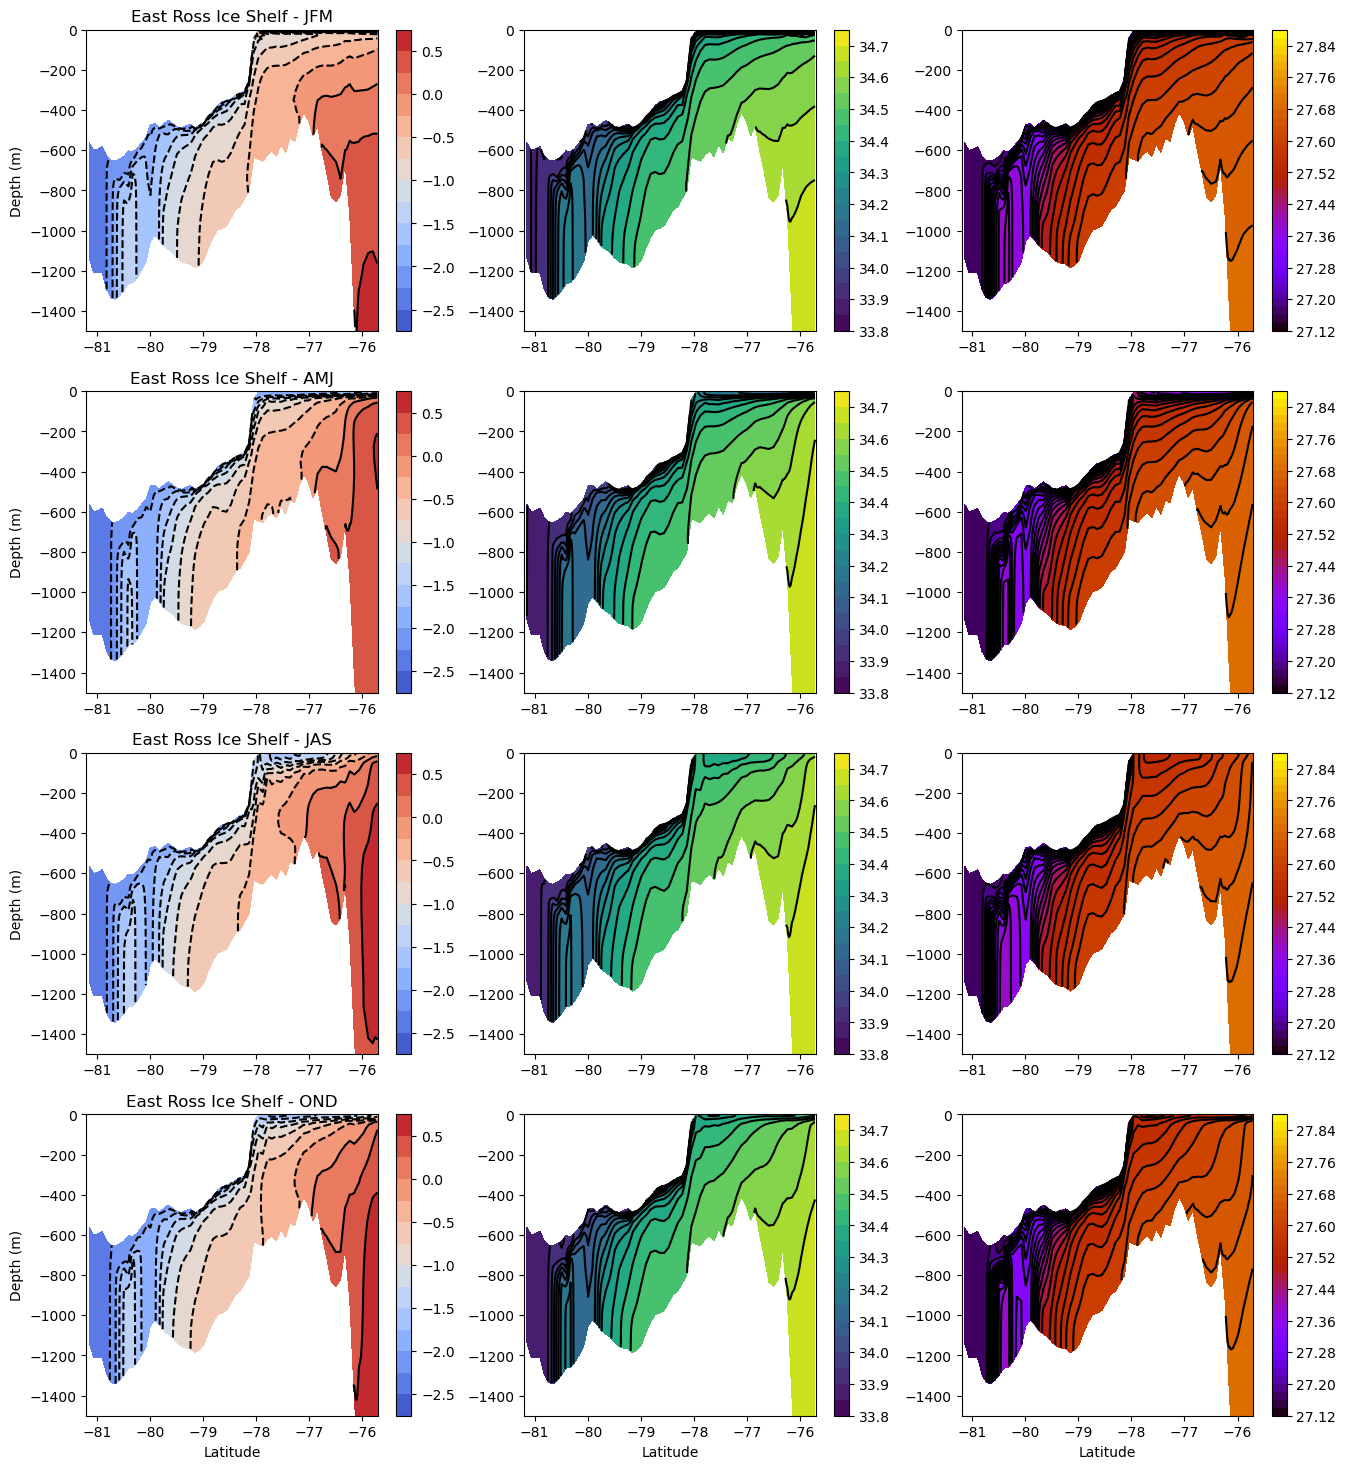

In [30]:
# Plot transects: Seasonal

# Ross East
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_temp_rosE_JFM, colors='k', levels=levelsT)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.title('East Ross Ice Shelf - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_salt_rosE_JFM, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JFM, section_rho_rosE_JFM, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_temp_rosE_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_temp_rosE_AMJ, colors='k', levels=levelsT)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_rho_rosE_AMJ, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.title('East Ross Ice Shelf - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_salt_rosE_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_salt_rosE_AMJ, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_rho_rosE_AMJ, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_rho_rosE_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_AMJ, section_rho_rosE_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_temp_rosE_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_temp_rosE_JAS, colors='k', levels=levelsT)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_rho_rosE_JAS, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.title('East Ross Ice Shelf - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_salt_rosE_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_salt_rosE_JAS, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_rho_rosE_JAS, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_rho_rosE_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_JAS, section_rho_rosE_JAS, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_OND, section_temp_rosE_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_OND, section_temp_rosE_OND, colors='k', levels=levelsT)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_OND, section_rho_rosE_OND, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.title('East Ross Ice Shelf - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_OND, section_salt_rosE_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_OND, section_salt_rosE_OND, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_OND, section_rho_rosE_OND, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_OND, section_rho_rosE_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_OND, section_rho_rosE_OND, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

name_fig="waom10extend_rosE_section_seas_yr20.png"
plt.savefig(fig_path + name_fig)

plt.show()

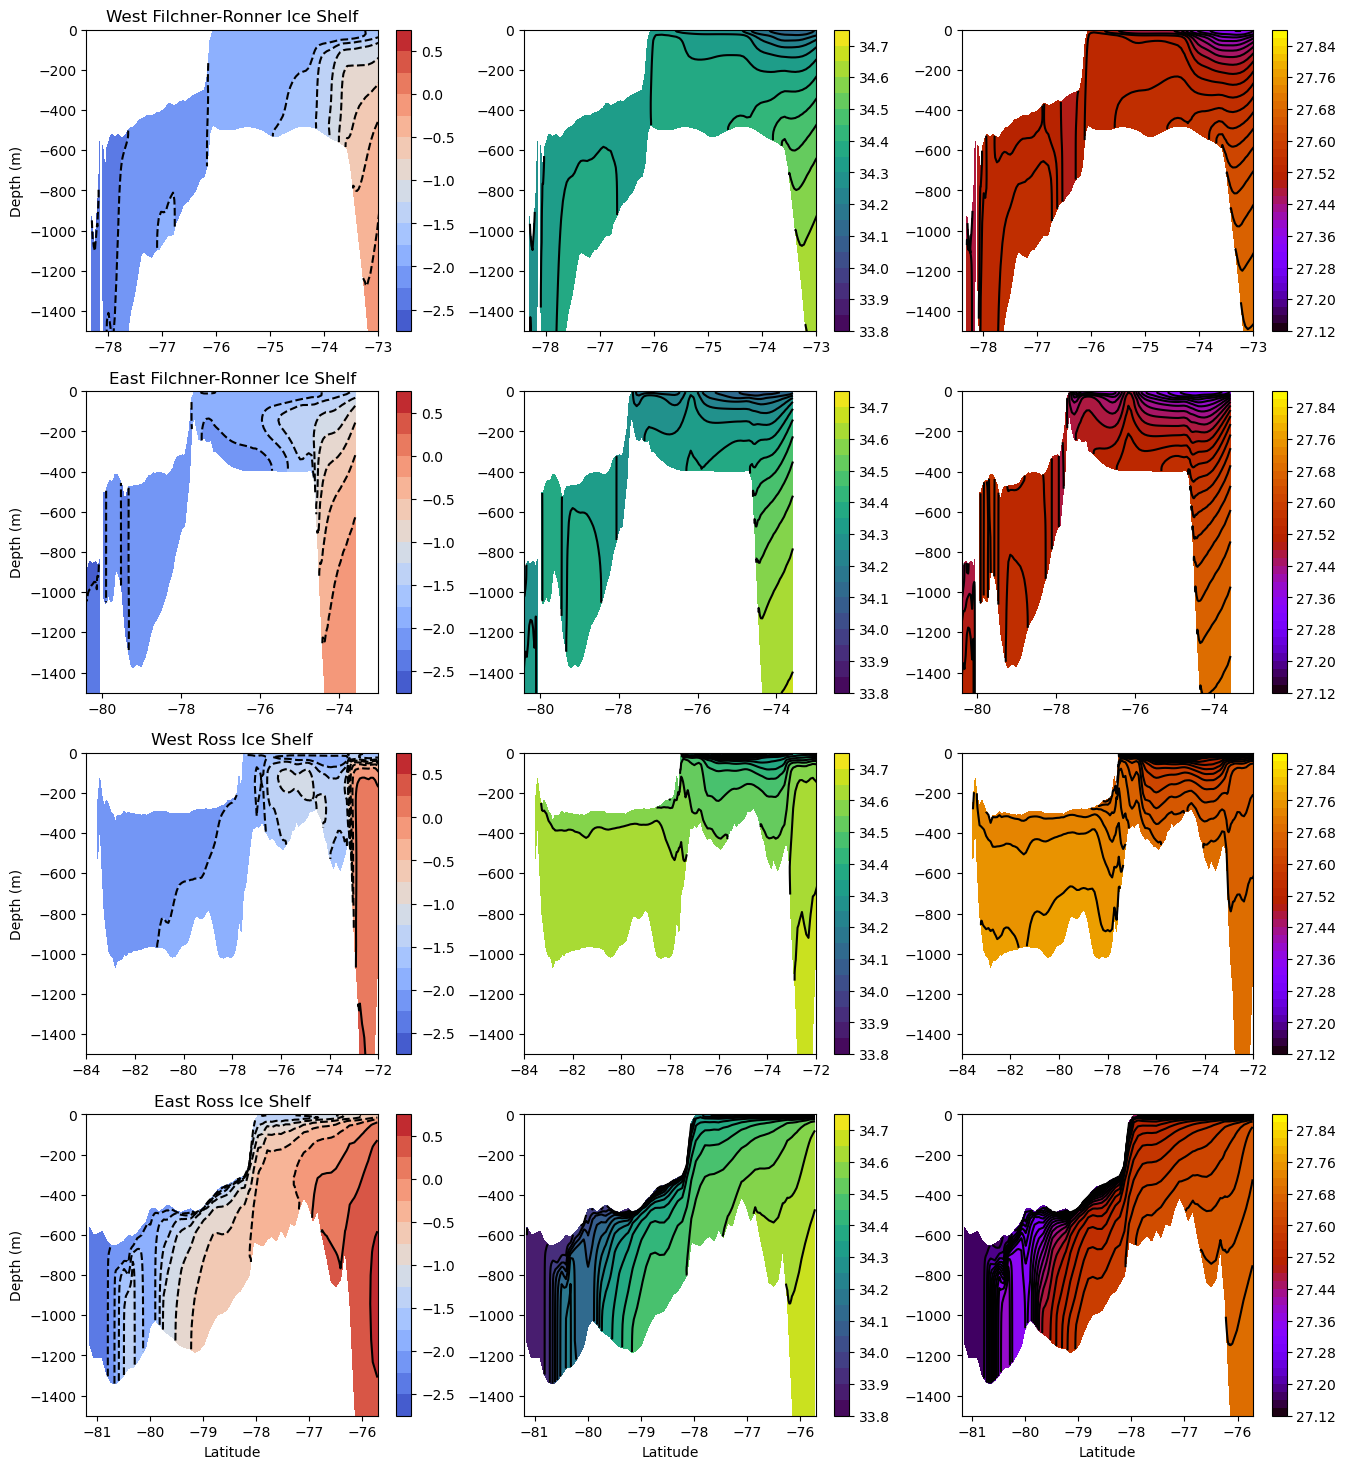

In [38]:
# Plot transects: Annual

# Weddell West
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_ann, section_temp_wedW_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_ann, section_temp_wedW_ann, colors='k', levels=levelsT)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_ann, section_rho_wedW_ann, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
plt.title('West Filchner-Ronner Ice Shelf')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_ann, section_salt_wedW_ann, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_ann, section_salt_wedW_ann, colors='k', levels=levelsS)
#plt.contour(section_lat_wedW_mask, section_z_wedW_mask_ann, section_rho_wedW_ann, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_wedW_mask, section_z_wedW_mask_ann, section_rho_wedW_ann, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedW_mask, section_z_wedW_mask_ann, section_rho_wedW_ann, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-78.4,-73.])
plt.ylim([-1500,0])

# Weddell East
ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_ann, section_temp_wedE_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_ann, section_temp_wedE_ann, colors='k', levels=levelsT)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_ann, section_rho_wedE_ann, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
plt.title('East Filchner-Ronner Ice Shelf')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_ann, section_salt_wedE_ann, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_ann, section_salt_wedE_ann, colors='k', levels=levelsS)
#plt.contour(section_lat_wedE_mask, section_z_wedE_mask_ann, section_rho_wedE_ann, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_wedE_mask, section_z_wedE_mask_ann, section_rho_wedE_ann, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wedE_mask, section_z_wedE_mask_ann, section_rho_wedE_ann, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-80.4,-73.])
plt.ylim([-1500,0])

# Ross West
ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_ann, section_temp_rosW_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_ann, section_temp_rosW_ann, colors='k', levels=levelsT)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_ann, section_rho_rosW_ann, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
plt.title('West Ross Ice Shelf')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_ann, section_salt_rosW_ann, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_ann, section_salt_rosW_ann, colors='k', levels=levelsS)
#plt.contour(section_lat_rosW_mask, section_z_rosW_mask_ann, section_rho_rosW_ann, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_rosW_mask, section_z_rosW_mask_ann, section_rho_rosW_ann, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosW_mask, section_z_rosW_mask_ann, section_rho_rosW_ann, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-84.,-72.])
plt.ylim([-1500,0])

# Ross East
ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_ann, section_temp_rosE_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_ann, section_temp_rosE_ann, colors='k', levels=levelsT)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_ann, section_rho_rosE_ann, colors='w', levels=levelsR)
plt.colorbar(ct)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.title('East Ross Ice Shelf')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_ann, section_salt_rosE_ann, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_ann, section_salt_rosE_ann, colors='k', levels=levelsS)
#plt.contour(section_lat_rosE_mask, section_z_rosE_mask_ann, section_rho_rosE_ann, colors='w', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_rosE_mask, section_z_rosE_mask_ann, section_rho_rosE_ann, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_rosE_mask, section_z_rosE_mask_ann, section_rho_rosE_ann, colors='k', levels=levelsR)
plt.colorbar(cs)
plt.xlim([-81.2,-75.7])
plt.ylim([-1500,0])
plt.xlabel('Latitude')

name_fig="waom10extend_RF-RISsections_annual_yr20.png"
plt.savefig(fig_path + name_fig)

plt.show()